In [17]:
import tensorflow as tf
import numpy as np
seed=2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [1]:
text = '''경마장에 있는 말이 뛰고 있다.
그의 말이 법이다.
가는 말이 고와야 오는 말이 곱다.'''


- 텍스트 전처리

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [3]:
#단어 집합 생성
t=Tokenizer()
t.fit_on_texts([text])

- 특징
    1. 가나다 순서가 아니고 많이 나온 단어 순서
    2. 1에서부터 시작함.(0이 없다. 패딩 할 때 0으로 채워야 하기 때문)

In [4]:

t.word_index

{'가는': 8,
 '경마장에': 2,
 '고와야': 9,
 '곱다': 11,
 '그의': 6,
 '뛰고': 4,
 '말이': 1,
 '법이다': 7,
 '오는': 10,
 '있는': 3,
 '있다': 5}

In [5]:
len(t.word_index)

11

In [19]:
#단어 집합 크기- keras.tokenizer의 시작 인덱스가 1이기 때문에 1을 더해줘야 함
#임베딩 때문?
vocab_size = len(t.word_index) + 1

In [6]:
t.texts_to_sequences(['그의 말이 법이다'])

[[6, 1, 7]]

In [7]:
#corpus를 encoding한 결과
for line in text.split('\n'):
    encoded=t.texts_to_sequences([line])[0]
    print(encoded)

[2, 3, 1, 4, 5]
[6, 1, 7]
[8, 1, 9, 10, 1, 11]


- sequence 생성

In [8]:
sequences=[]
for line in text.split('\n'):
    encoded= t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequences.append(encoded[:i+1])

sequences

[[2, 3],
 [2, 3, 1],
 [2, 3, 1, 4],
 [2, 3, 1, 4, 5],
 [6, 1],
 [6, 1, 7],
 [8, 1],
 [8, 1, 9],
 [8, 1, 9, 10],
 [8, 1, 9, 10, 1],
 [8, 1, 9, 10, 1, 11]]

In [10]:
#시퀀스 중 가장 긴 것
max_len=max(len(seq) for seq in sequences)

max_len

- padding
    - 전체 샘플 길이를 max_len에 맞추도록 0을 추가
    - 앞쪽을 채우는 pre 옵션이 디폴트

In [12]:
sequences=pad_sequences(sequences,maxlen=max_len, padding='pre')
sequences[:5]

array([[0, 0, 0, 0, 2, 3],
       [0, 0, 0, 2, 3, 1],
       [0, 0, 2, 3, 1, 4],
       [0, 2, 3, 1, 4, 5],
       [0, 0, 0, 0, 6, 1]], dtype=int32)

- X,y 데이터 설정

In [13]:
X=sequences[:,:-1]
y=sequences[:,-1]
X.shape, y.shape

((11, 5), (11,))

In [14]:
Y=to_categorical(y)
Y.shape

(11, 12)

### 모델
- Embedding
- simpleRNN
- Dense

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

In [20]:
# Embedding =4, simpleRNN =32
# Embedding vector의 갯수가 rnn layer에서 feature 갯수
model=Sequential ([
                   Embedding(vocab_size,4,input_length=max_len-1),
                   SimpleRNN(32), #activation='tanh'는 디폴트.
                   Dense(vocab_size,activation='softmax')
                   ])
model.summary()
#((4+32)*32)+32=1184

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 4)              48        
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1184      
                                                                 
 dense (Dense)               (None, 12)                396       
                                                                 
Total params: 1,628
Trainable params: 1,628
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile('adam','categorical_crossentropy',metrics=['accuracy'])

In [22]:
hist=model.fit(X,Y,epochs=200,verbose=0)

In [23]:
hist.history['accuracy'][-1]

1.0

In [24]:
cd /content/drive/MyDrive/Colab Notebooks/DeepLearning_2022_05/04.RNN

/content/drive/MyDrive/Colab Notebooks/DeepLearning_2022_05/04.RNN


In [25]:
from my_util import sentence_generation
sentence_generation(model,t,max_len,'경마장에',3)
#모델,토크나이저,maxlen,현재 단어, 반복 횟수

'경마장에 있는 말이 뛰고'

In [28]:
sentence_generation(model,t,max_len,'가는',5)


'가는 말이 고와야 오는 말이 곱다'

### 모델 변화
- 임베딩 백터 갯수 [2,4,6]
- rnn 유닛 갯수[24,32,48]

In [32]:
for n_embed in [2,4,6]:
    for n_unit in [24,32,48]:
        model=Sequential ([
                   Embedding(vocab_size,n_embed,input_length=max_len-1),
                   SimpleRNN(n_unit), #activation='tanh'는 디폴트.
                   Dense(vocab_size,activation='softmax')
                   ])
        model.compile('adam','categorical_crossentropy',metrics=['accuracy'])
        hist=model.fit(X,Y,epochs=200,verbose=0)
        print('----------------------------------')
        print(f'Embedding vector:{n_embed}, RNN Unit:{n_unit}')
        print(f"정확도:{hist.history['accuracy'][-1]:.4f}")
        print(sentence_generation(model,t,max_len,'경마장에',4))
        print(sentence_generation(model,t,max_len,'그의',2))
        print(sentence_generation(model,t,max_len,'가는',5))
        print()

----------------------------------
Embedding vector:2, RNN Unit:24
정확도:0.8182
경마장에 말이 말이 오는 말이
그의 말이 법이다
가는 말이 법이다 오는 말이 곱다

----------------------------------
Embedding vector:2, RNN Unit:32
정확도:0.8182
경마장에 말이 법이다 오는 말이
그의 말이 고와야
가는 말이 고와야 오는 말이 곱다

----------------------------------
Embedding vector:2, RNN Unit:48
정확도:0.9091
경마장에 말이 고와야 오는 말이
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다

----------------------------------
Embedding vector:4, RNN Unit:24
정확도:0.8182
경마장에 말이 말이 오는 말이
그의 말이 법이다
가는 말이 법이다 오는 말이 곱다

----------------------------------
Embedding vector:4, RNN Unit:32
정확도:1.0000
경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다

----------------------------------
Embedding vector:4, RNN Unit:48
정확도:0.9091
경마장에 말이 고와야 오는 말이
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다

----------------------------------
Embedding vector:6, RNN Unit:24
정확도:1.0000
경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다

----------------------------------
Embedding vector:6, RNN Unit:32
정확도:1.0000
경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱

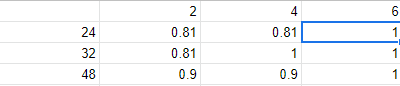